<h1 style="color:blue">Project Libraries</h1>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers

<h1 style="color:blue">Exploratory Data Analysis (EDA)</h1>

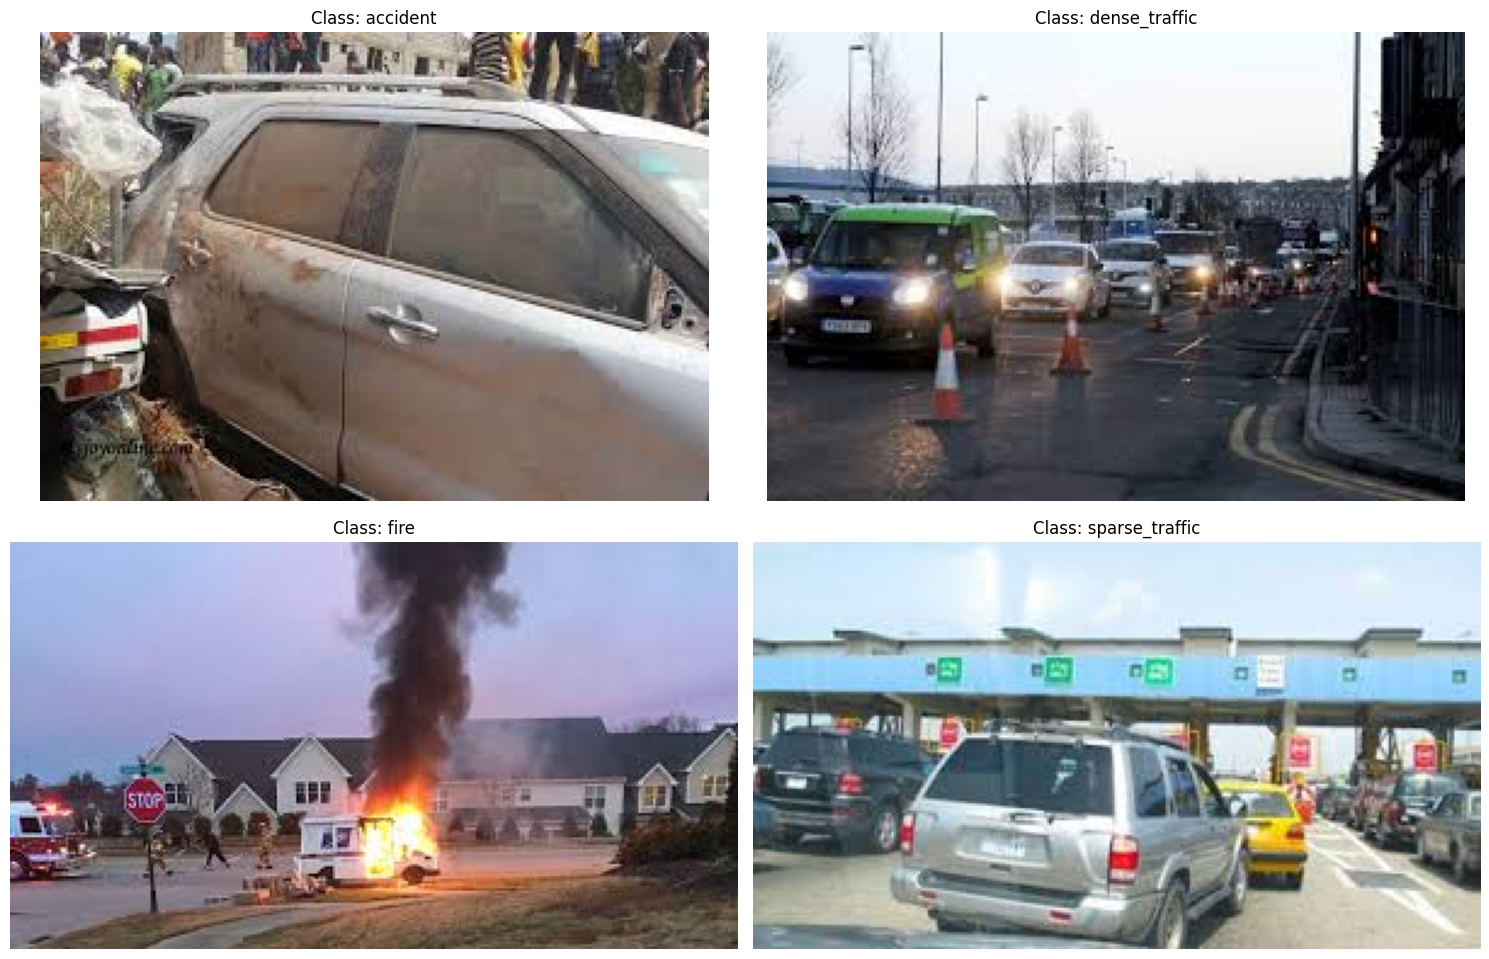

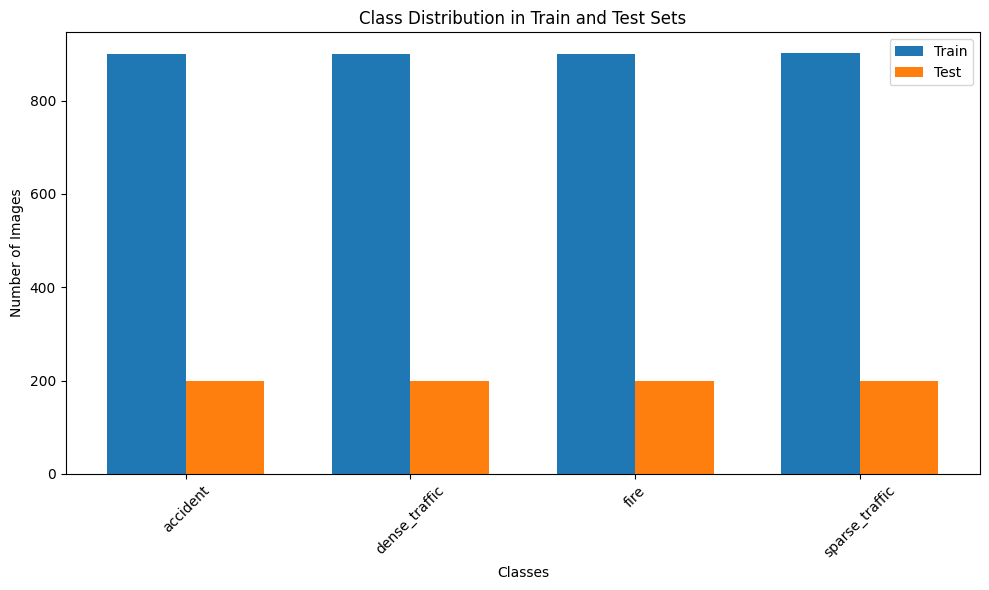

In [2]:
def perform_eda(data_path):
    class_names = ['accident', 'dense_traffic', 'fire', 'sparse_traffic']
    
    plt.figure(figsize=(15, 10))
    for idx, class_name in enumerate(class_names):
        # Getting sample images from train folder
        train_path = os.path.join(data_path, 'train', class_name)
        sample_image_name = os.listdir(train_path)[0]  # Get first image
        sample_image_path = os.path.join(train_path, sample_image_name)
        
        # Loading and displaying an image
        img = tf.keras.utils.load_img(sample_image_path)
        plt.subplot(2, 2, idx + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Displaying the dataset class distribution
    class_distribution = {}
    for class_name in class_names:
        train_path = os.path.join(data_path, 'train', class_name)
        test_path = os.path.join(data_path, 'test', class_name)
        train_count = len(os.listdir(train_path))
        test_count = len(os.listdir(test_path))
        class_distribution[class_name] = {'train': train_count, 'test': test_count}
    
    # Plotting class distribution
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.35
    
    plt.bar(x - width/2, [class_distribution[c]['train'] for c in class_names], 
            width, label='Train')
    plt.bar(x + width/2, [class_distribution[c]['test'] for c in class_names], 
            width, label='Test')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Train and Test Sets')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Executing EDA
data_path = r"./trafficnet_dataset_v1"
perform_eda(data_path)

<h1 style="color:blue">Data Preprocessing</h1>

In [3]:
def preprocess_data(data_path, img_height=224, img_width=224):
    # Creating data generators with augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'train'),
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=32
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'train'),
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=32
    )
    
    # Configuring dataset performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    # Applying data augmentation to training dataset
    train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=AUTOTUNE
    )
    
    return train_ds, val_ds

# Preprocessing data
train_ds, val_ds = preprocess_data(data_path)

Found 3600 files belonging to 4 classes.
Using 2880 files for training.
Found 3600 files belonging to 4 classes.
Using 720 files for validation.


<h1 style="color:blue">Model Development</h1>

In [4]:
def build_model(img_height=224, img_width=224, num_classes=4):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

def train_model(model, train_ds, val_ds, epochs=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping]
    )
    
    return history

# Building and training model
model = build_model()
history = train_model(model, train_ds, val_ds)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 87s 830ms/step - accuracy: 0.5009 - loss: 1.1168 - val_accuracy: 0.6778 - val_loss: 0.8370
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 788ms/step - accuracy: 0.6642 - loss: 0.8490 - val_accuracy: 0.6389 - val_loss: 0.9249
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 859ms/step - accuracy: 0.7076 - loss: 0.7503 - val_accuracy: 0.6472 - val_loss: 0.8767
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 854ms/step - accuracy: 0.7117 - loss: 0.7362 - val_accuracy: 0.6764 - val_loss: 0.8210
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 783ms/step - accuracy: 0.7105 - loss: 0.7264 - val_accuracy: 0.6333 - val_loss: 0.9168
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 781ms/step - accuracy: 0.7038 - loss: 0.7324 - val_accuracy: 0.6597 - val_loss: 0.8510
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 800ms/step - accuracy: 0.7392 - loss: 0.6701 - val_accuracy: 0.7194 - val_loss: 0.7253
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 819ms/step - accuracy: 0.7503 - loss: 0.6581 - val_accu

<h1 style="color:blue">Model Evaluation</h1>

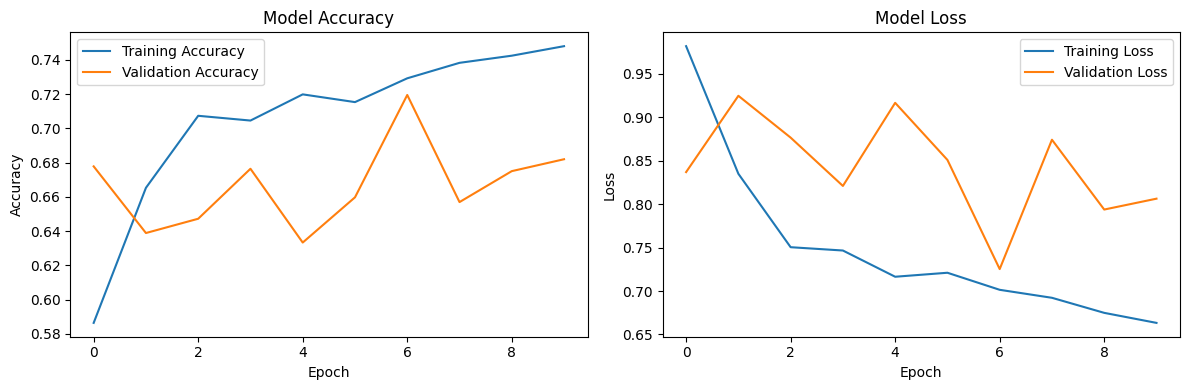

Found 800 files belonging to 4 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 591ms/step - accuracy: 0.7348 - loss: 0.6998
Test Loss: 0.7153
Test Accuracy: 0.7350


In [5]:
def evaluate_model(model, history):
    # Plotting training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluating on test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_path, 'test'),
        image_size=(224, 224),
        batch_size=32
    )
    
    test_results = model.evaluate(test_ds)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")

# Evaluating the model
evaluate_model(model, history)

In [6]:
#Saving the model to be tested on an App
model.save('traffic_model.h5')